# GoogLeNet
GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。 这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。 毕竟，以前流行的网络使用小到  1×1  ，大到  11×11  的卷积核。 本文的一个观点是，有时使用不同大小的卷积核组合是有利的。 在本节中，我们将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，但是现在有了更好的训练算法，这些特性不是必要的。

## 1、Inception块
在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。

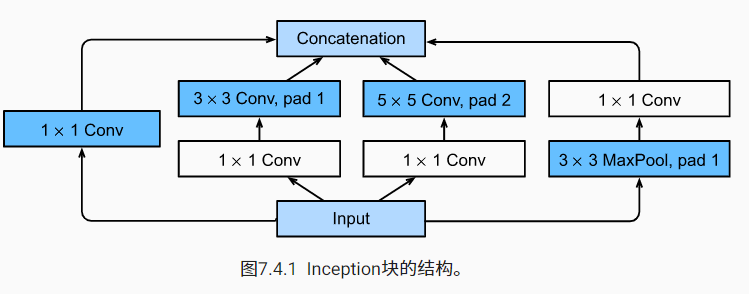

Inception块由四条并行路径组成。 前三条路径使用窗口大小为  1×1 、 3×3  和  5×5  的卷积层，从不同空间大小中提取信息。 中间的两条路径在输入上执行  1×1  卷积，以减少通道数，从而降低模型的复杂性。 第四条路径使用  3×3  最大池化层，然后使用  1×1  卷积层来改变通道数。 这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道的数量。

那么为什么GoogLeNet这个网络如此有效呢？ 首先我们考虑一下滤波器（filter）的组合，它们可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。 同时，我们可以为不同的滤波器分配不同数量的参数

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import sys
sys.path.append('../../CommonFunctions/tools/')
import common_tools

In [3]:
class Inception(nn.Module):
    # `c1`--`c4` 是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

## 2、GoogLeNet模型
GoogLeNet 一共使用 9 个Inception块和全局平均池化层的堆叠来生成其估计值。Inception块之间的最大池化层可降低维度。 第一个模块类似于 AlexNet 和 LeNet，Inception块的栈从VGG继承，全局平均池化层避免了在最后使用全连接层。

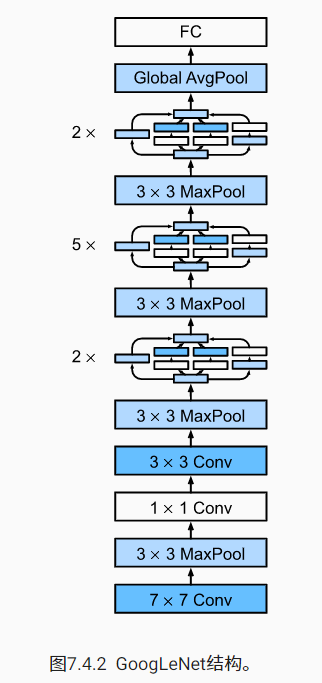

第一个模块使用 64 个通道、  7×7  卷积层。

In [4]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第二个模块使用两个卷积层：第一个卷积层是 64个通道、  1×1  卷积层；第二个卷积层使用将通道数量增加三倍的  3×3  卷积层。 这对应于 Inception 块中的第二条路径。

In [5]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1), 
    nn.ReLU(), 
    nn.Conv2d(64, 192, kernel_size=3, padding=1), 
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第三个模块串联两个完整的Inception块。 

第一个 Inception 块的输出通道数为  64+128+32+32=256 ，四个路径之间的输出通道数量比为  64:128:32:32=2:4:1:1 。 

第二个和第三个路径首先将输入通道的数量分别减少到  96/192=1/2  和  16/192=1/12 ，然后连接第二个卷积层。

第二个 Inception 块的输出通道数增加到  128+192+96+64=480 ，四个路径之间的输出通道数量比为  128:192:96:64=4:6:3:2 。 

第二条和第三条路径首先将输入通道的数量分别减少到  128/256=1/2  和  32/256=1/8 。


In [6]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32), 
                   Inception(256, 128, (128, 192), (32, 96), 64), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第四模块更加复杂， 它串联了5个Inception块，其输出通道数分别是  192+208+48+64=512  、  160+224+64+64=512  、  128+256+64+64=512  、  112+288+64+64=528  和  256+320+128+128=832  。 

这些路径的通道数分配和第三模块中的类似，首先是含  3×3  卷积层的第二条路径输出最多通道，其次是仅含  1×1  卷积层的第一条路径，之后是含  5×5  卷积层的第三条路径和含  3×3  最大池化层的第四条路径。 

其中第二、第三条路径都会先按比例减小通道数。 这些比例在各个 Inception 块中都略有不同。

In [7]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五模块包含输出通道数为  256+320+128+128=832  和  384+384+128+128=1024  的两个Inception块。 

其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。 

需要注意的是，第五模块的后面紧跟输出层，该模块同 NiN 一样使用全局平均池化层，将每个通道的高和宽变成1。 最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。

In [9]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

GoogLeNet 模型的计算复杂，而且不如 VGG 那样便于修改通道数。 为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96，这简化了计算。下面演示各个模块输出的形状变化。

In [10]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## 3、训练模型

loss 0.249, train acc 0.905, test acc 0.882
1996.7 examples/sec on cuda:2


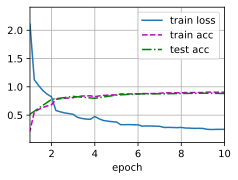

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = common_tools.load_data_fashion_mnist(batch_size, resize=96)
common_tools.train_ch6(net, train_iter, test_iter, 
                       num_epochs, lr, common_tools.try_gpu(2))

## 4、结合GoogLeNet论文实现

### 定义Inception块

In [19]:
class Inception(nn.Module):
    def __init__(self,in_channels,c1,c2,c3,c4):
        super(Inception,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,c1,kernel_size = 1)
        self.conv2 = nn.Sequential(
                    nn.Conv2d(in_channels,c2[0],kernel_size = 1),
                    nn.ReLU(),
                    nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1),
                    nn.ReLU()
                )
        self.conv3 = nn.Sequential(
                    nn.Conv2d(in_channels,c3[0],kernel_size=1),
                    nn.ReLU(),
                    nn.Conv2d(c3[0],c3[1],kernel_size=5, padding=2),
                    nn.ReLU()
                )
        self.conv4 = nn.Sequential(
                    nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
                    nn.Conv2d(in_channels,c4,kernel_size = 1),
                    nn.ReLU(),
                )
    def forward(self,X):
        
        return torch.cat(
            (
            self.conv1(X),
            self.conv2(X),
            self.conv3(X),
            self.conv4(X),
            ),dim = 1)

### 实现GoogleNet模型

In [20]:
class GoogleNet(nn.Module):
    def __init__(self,in_channels,classes):
        super(GoogleNet,self).__init__()
        self.model = nn.Sequential(
                  nn.Conv2d(in_channels,out_channels=64,kernel_size=7,stride=2,padding=3),nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3,stride=2),
                  nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1),nn.ReLU(),
                  nn.Conv2d(in_channels=64,out_channels=192,kernel_size=3,padding=1),nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3,stride=2),
                  Inception(192,c1=64,c2=[96,128],c3=[16,32],c4=32),
                  Inception(256,c1=128,c2=[128,192],c3=[32,96],c4=64),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
                  Inception(480,c1=192,c2=[96,208],c3=[16,48],c4=64),
                  Inception(512,c1=160,c2=[112,224],c3=[24,64],c4=64),
                  Inception(512,c1=128,c2=[128,256],c3=[24,64],c4=64),
                  Inception(512,c1=112,c2=[144,288],c3=[32,64],c4=64),
                  Inception(528,c1=256,c2=[160,320],c3=[32,128],c4=128),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
                  Inception(832,c1=256,c2=[160,320],c3=[32,128],c4=128),
                  Inception(832,c1=384,c2=[192,384],c3=[48,128],c4=128),
                  nn.AvgPool2d(kernel_size=7,stride=1),
                  nn.Dropout(p=0.4),
                  nn.Flatten(),
                  nn.Linear(1024,classes),
                  nn.Softmax(dim=1)
                )
    def forward(self,X:torch.tensor):
        for layer in self.model:
            X = layer(X)
            print(layer.__class__.__name__,'output shape:',X.shape)

### 模型测试

In [21]:
X = torch.randn(size=(1,3,224,224))
net = GoogleNet(3,1000)
net(X)

Conv2d output shape: torch.Size([1, 64, 112, 112])
ReLU output shape: torch.Size([1, 64, 112, 112])
MaxPool2d output shape: torch.Size([1, 64, 55, 55])
Conv2d output shape: torch.Size([1, 64, 55, 55])
ReLU output shape: torch.Size([1, 64, 55, 55])
Conv2d output shape: torch.Size([1, 192, 55, 55])
ReLU output shape: torch.Size([1, 192, 55, 55])
MaxPool2d output shape: torch.Size([1, 192, 27, 27])
Inception output shape: torch.Size([1, 256, 27, 27])
Inception output shape: torch.Size([1, 480, 27, 27])
MaxPool2d output shape: torch.Size([1, 480, 14, 14])
Inception output shape: torch.Size([1, 512, 14, 14])
Inception output shape: torch.Size([1, 512, 14, 14])
Inception output shape: torch.Size([1, 512, 14, 14])
Inception output shape: torch.Size([1, 528, 14, 14])
Inception output shape: torch.Size([1, 832, 14, 14])
MaxPool2d output shape: torch.Size([1, 832, 7, 7])
Inception output shape: torch.Size([1, 832, 7, 7])
Inception output shape: torch.Size([1, 1024, 7, 7])
AvgPool2d output shape: